In [ ]:
import numpy as np
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import torch
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

def readImg(path): # Function to read the images and return a torch tensor of floats of size (256,256)
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_RGBA2BGR).astype(np.float32)
    img = cv2.resize(img,(256,256))
    return torch.tensor(img,dtype=torch.float32)

### **Generating Synthetic Images :**

In [ ]:
import pandas as pd
import random

columns = ["filename","xmin","ymin","xmax","ymax","class"]
df = pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])

for count in range(7000):
    synth_img = cv2.imread('/content/result_Page_7.jpg')
    top, left  = 435 , random.randint(-17,-15)+150
    bottom , right = top + 70 , left +160
    synth_img[(425):600, 100:750] = (255,255,255)

    for i in range(5):
        image = random.choice(glob('/content/symbols/*'))
        img = cv2.imread(image)
        img = cv2.cvtColor(img,cv2.COLOR_RGBA2BGR).astype(np.float32)
        img = cv2.resize(img,(160,70))
        
        synth_img[int(top):int(bottom), int(left):int(right)] = img
        classes = (image.split(".")[-2].split('/')[-1])
        row = ['augmented_98/'+ str(count)+'.jpg', left,top,right,bottom,classes]
        df.loc[len(df.index)] = row
        row = ['augmented_98/'+ str(count)+'.jpg', 1049,126,1244,227,4]
        df.loc[len(df.index)] = row

        left = right + random.randint(30,40)
        right = left + 160

        if i == 3 :
          top, left  = 435 + 72 , 150
          bottom , right = top + 70 , 150+160
      
    cv2.imwrite('augmented_98/'+ str(count) +'.jpg',synth_img)


In [ ]:
df.head(5)

,filename,xmin,ymin,xmax,ymax,class
0,augmented_98/0.jpg,134,435,294,505,6
1,augmented_98/0.jpg,328,435,488,505,8
2,augmented_98/0.jpg,528,435,688,505,1
3,augmented_98/0.jpg,719,435,879,505,6
4,augmented_98/0.jpg,150,507,310,577,4


### **Code to Visualization synthetic Data :**

In [ ]:
def get_aug_pipeline():

    transforms = []
    # transforms.append( )
    transforms.append(A.Resize(512, 512, p=1.0))
    transforms.append(ToTensorV2(p=1))

    return A.Compose(
        transforms, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    )

augmented_98/0.jpg


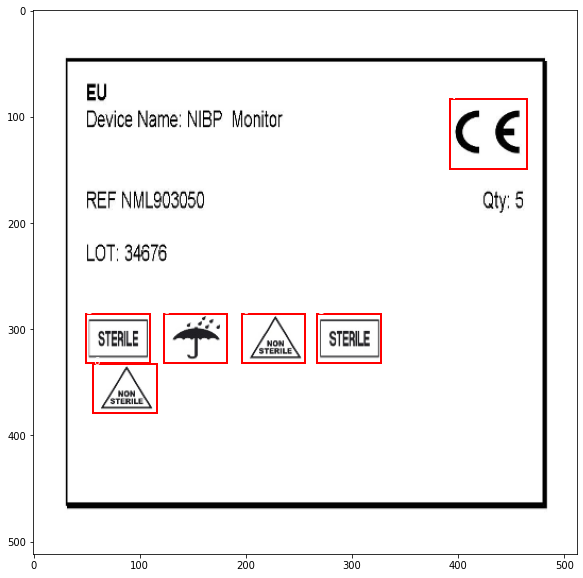

augmented_98/1.jpg


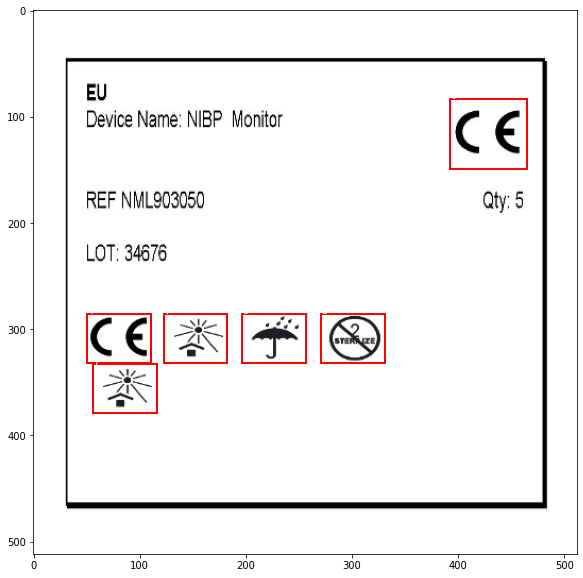

augmented_98/2.jpg


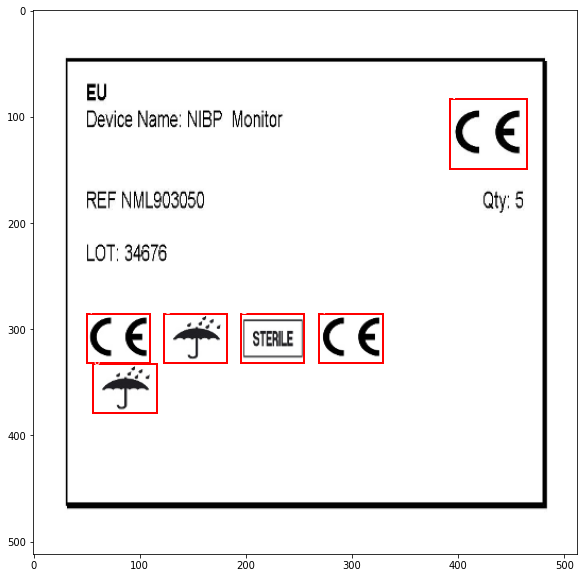

In [ ]:
def show_output_with_bbox(filename, bboxes, labels, transform):

    image = cv2.imread(filename) # cv2.IMREAD_COLOR
    print(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = image/255.0

    aug_pipeline = get_aug_pipeline()
    transformed = aug_pipeline(image=image, bboxes=bboxes, labels=labels)

    img = transformed['image']
    bboxes = torch.as_tensor(transformed['bboxes'])
    bboxes = bboxes.detach().numpy()
    labels = transformed['labels']



    
    img_height = img.shape[1]
    img_width = img.shape[2]
    
    fig, ax = plt.subplots(figsize=(10,10))

    ax.imshow(img.permute(1,2,0).numpy())
    

    for bbox, class_name in zip(bboxes, labels):
        xmin = bbox[0]
        ymin = bbox [1]
        width = bbox[2] - xmin
        height = bbox[3] - ymin

        # xmin, ymin, width, height = [x for x in [(xcenter-(width/2)), (ycenter-(height/2)), width, height]]
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, class_name, color='w')
        
    
    
    plt.show()
    

################################################################################

trainFiles = df['filename'].unique().tolist()

for filename in trainFiles[:3]:
    records = df[df['filename']==filename]


    bboxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

    labels = records[['class']].values

    labels = [x[0] for x in labels]
    area = (bboxes[:,2]-bboxes[:,0]) * (bboxes[:,3]-bboxes[:,1])

    show_output_with_bbox(filename, bboxes, labels, get_aug_pipeline())


In [ ]:
from albumentations.pytorch.transforms import ToTensorV2

# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
# https://albumentations.ai/docs/api_reference/core/composition/


# global class_int_dict
class_int_dict = {
    "background":0,
    "1":1,
    "2":2,
    "3":3,
    "4":4,
    "5":5,
    "6":6,
    "7":7,
    "8":8,
    "9":9
}

In [ ]:
def get_resize_aug1():
    return A.Compose([A.Resize(512, 512, p=1.0),
                      ToTensorV2(p=1)],
                      bbox_params=A.BboxParams(format='pascal_voc', min_area=0.0, min_visibility=0.0, label_fields=['labels']))
def get_resize_aug2():
    return A.Compose([A.Resize(512, 512, p=1.0),
                      ToTensorV2(p=1)],
                      bbox_params=A.BboxParams(format='pascal_voc', min_area=0.0, min_visibility=0.0, label_fields=['labels']))
    
def normal():
    return A.Compose([A.Resize(512, 512, p=1.0),
                      ToTensorV2(p=1)],
                      bbox_params=A.BboxParams(format='pascal_voc', min_area=0.0, min_visibility=0.0, label_fields=['labels']))

### **Data Loader :**

In [ ]:
class LogoDataset(Dataset):
    
    def __init__(self, DF, train):

        self.train = train
        self.DF = DF
        self.filenames = self.DF['filename'].unique()
        self.noOfUniqueFiles = len(self.filenames)
        self.resize1 = get_resize_aug1()
        self.resize2 = get_resize_aug2()
        self.normal = normal()
        self.transforms = None

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):

        transformed = None
        
        image_id = self.filenames[index]
        records = self.DF[self.DF['filename'] == image_id]
        img = cv2.imread(image_id, cv2.IMREAD_ANYCOLOR) # cv2.IMREAD_COLOR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = img/255.0

        bboxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
        class_labels = records[['class']].values.reshape(1, -1)[0]
        class_labels = [class_int_dict[str(i)] for i in class_labels]

        if self.train:

            self.transforms = self.resize1
            transformed = self.transforms(image=img, bboxes=bboxes, labels=class_labels)
      
        else:
            self.transforms = self.normal
            transformed = self.transforms(image=img, bboxes=bboxes, labels=class_labels)

        
        img = transformed['image']
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        num_objs = len(bboxes)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        class_label = torch.tensor(transformed['labels'])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["labels"] = class_label # tensor
        target["boxes"] = bboxes # tensor
        target['image_id'] = torch.tensor([index]) # string
        target['iscrowd'] = iscrowd
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

        return img, target

In [ ]:
train_dataset = LogoDataset(DF=df, train=True)

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 5,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


### **Modelling :**

In [ ]:
SSD_MODEL = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=False, num_classes=10)
SSD_MODEL
def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

device(type='cuda')

In [ ]:
!git clone https://github.com/pytorch/vision.git
!ln -s ./vision/references/detection/engine.py engine.py
!ln -s ./vision/references/detection/train.py train.py
!ln -s ./vision/references/detection/utils.py utils.py
!ln -s ./vision/references/detection/coco_utils.py coco_utils.py
!ln -s ./vision/references/detection/group_by_aspect_ratio.py group_by_aspect_ratio.py
!ln -s ./vision/references/detection/presets.py presets.py
!ln -s ./vision/references/detection/coco_eval.py coco_eval.py
!ln -s ./vision/references/detection/transforms.py transforms.py

Cloning into 'vision'...
remote: Enumerating objects: 254088, done.
remote: Counting objects: 100% (6767/6767), done.
remote: Compressing objects: 100% (433/433), done.
remote: Total 254088 (delta 6359), reused 6682 (delta 6320), pack-reused 247321
Receiving objects: 100% (254088/254088), 511.98 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (231260/231260), done.


In [ ]:
!pip install -q pycocotools
from engine import train_one_epoch, evaluate
import utils

In [ ]:
torch.cuda.empty_cache()

def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device
if torch.cuda.is_available():
    SSD_MODEL.cuda()

params = [p for p in SSD_MODEL.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
EPOCHS = 5

loss_stats = {
    'train': [],
    "val": []
}
# TRAINING
print("Begin training.")
for e in tqdm(range(EPOCHS)):
    epoch_loss = []
    SSD_MODEL.train()
    for i, data in enumerate(train_data_loader):
                                 
        images, targets = data
        optimizer.zero_grad()
  
        inputs = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # pass input to model
        loss_dict_train = SSD_MODEL(inputs, targets)

        # loss
        losses_train = sum(loss for loss in loss_dict_train.values())
        epoch_loss.append(losses_train.item())

        # backprop
        losses_train.backward()

        # update weights
        optimizer.step()
        #------====------#
    
    # Epoch end - Training loss
    train_loss_epoch = np.mean(epoch_loss)
    loss_stats['train'].append(train_loss_epoch)
   
    print(f'Epoch {e+0:03}: | Train Loss: {train_loss_epoch :.5f}')
    torch.save({
    'epoch': e,
    'model_state_dict': SSD_MODEL.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, f"/content/drive/MyDrive/Glove_6B/augmented_98.pth")

    


    

Begin training.


 20%|██        | 1/5 [03:35<14:21, 215.38s/it]

Epoch 000: | Train Loss: 0.03405


 40%|████      | 2/5 [07:11<10:48, 216.00s/it]

Epoch 001: | Train Loss: 0.03283


 60%|██████    | 3/5 [11:03<07:25, 222.99s/it]

Epoch 002: | Train Loss: 0.03679


 80%|████████  | 4/5 [14:40<03:40, 220.90s/it]

Epoch 003: | Train Loss: 0.03869


### **Model Validation :**

In [ ]:
def show_output_with_bbox(img, bboxes, labels, scores):

    print(img.shape)
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    fig, ax = plt.subplots(figsize=(12,12))

    ax.imshow(img)

    for box, class_name, score in zip(bboxes, labels, scores):

        if score >= 0.2:

            class_name = class_dict[class_name]
            xmin, ymin, xmax, ymax = box
            xmin, ymin, width, height = [x for x in [xmin, ymin, (xmax-xmin), (ymax-ymin)]]
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{class_name, np.round(score, 2)}", color='r', fontsize='large')

            # {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    
    plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(300, 300, 3)


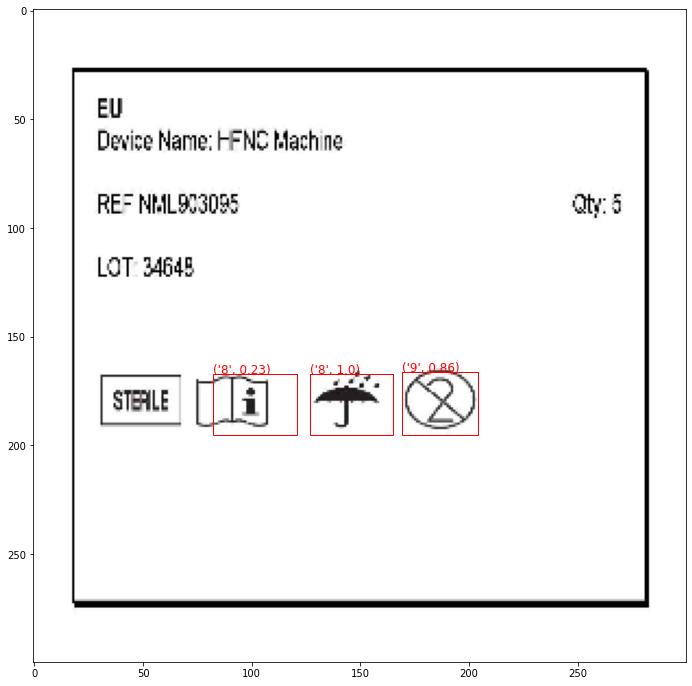

(300, 300, 3)


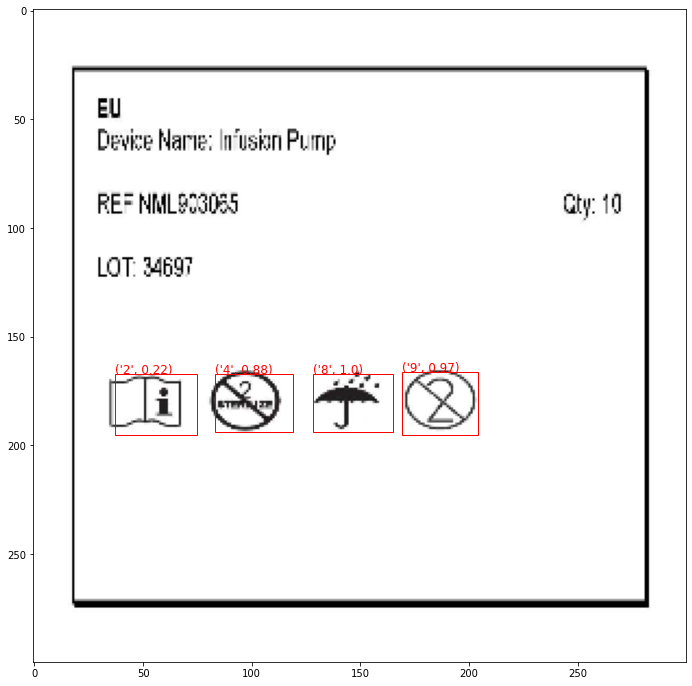

(300, 300, 3)


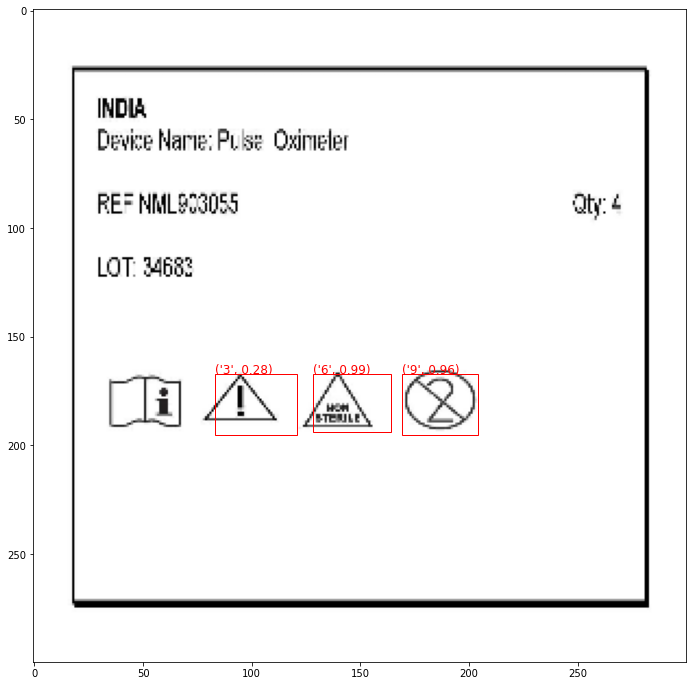

(300, 300, 3)


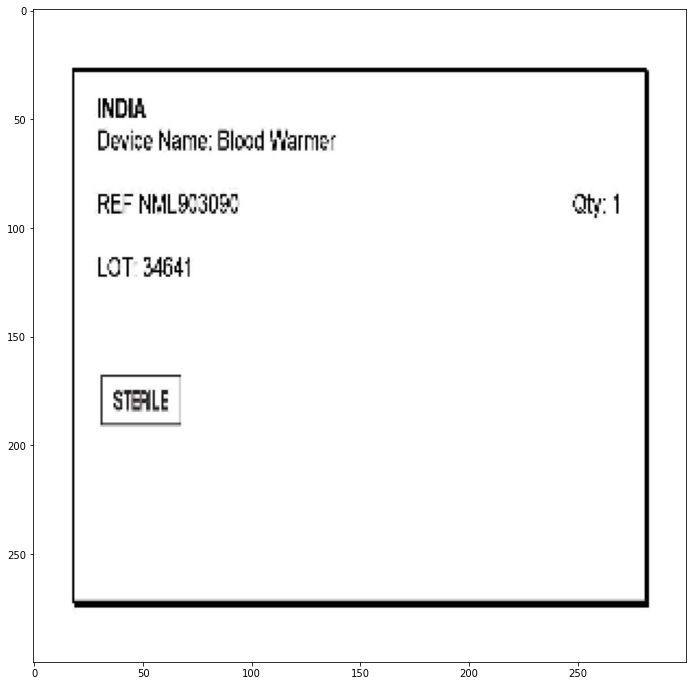

(300, 300, 3)


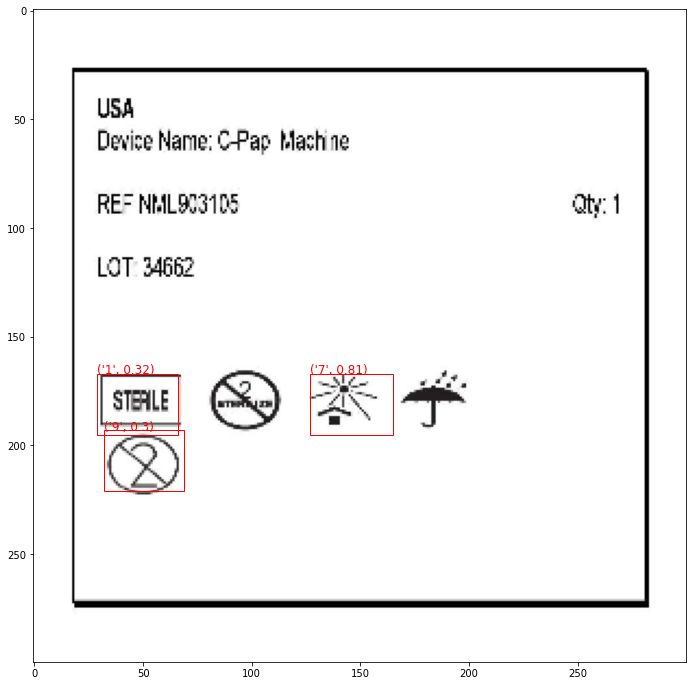

(300, 300, 3)


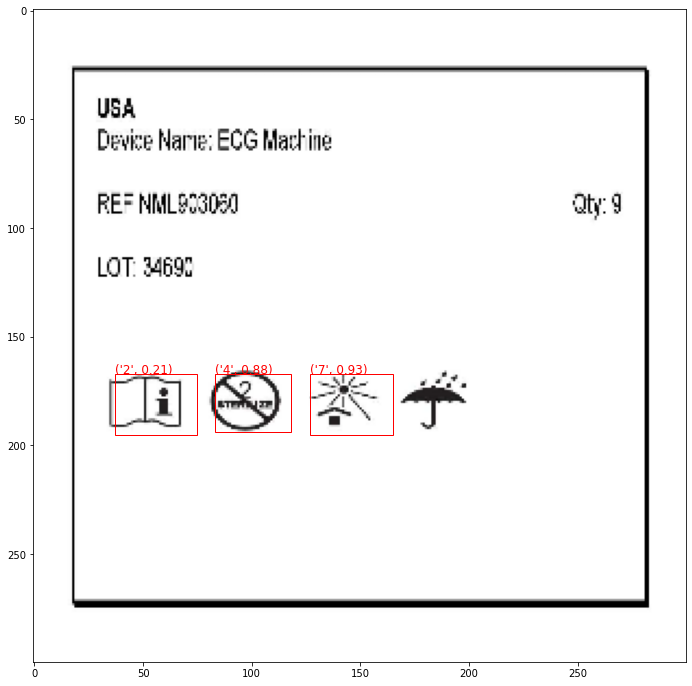

In [ ]:
class_dict = {
    0:"background",
    1:"1",
    2:"2",
    3:"3",
    4:"4",
    5:"5",
    6:"6",
    7:"7",
    8:"8",
    9:"9"
}

for image in glob("images/*"):
    img = cv2.imread(image)
    img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0


    SSD_MODEL.eval()
    img_tensor_float = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0).to(device)
    out = SSD_MODEL(img_tensor_float)

    keepIndex = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], iou_threshold=0.1)

    bboxTensors = out[0]['boxes'][keepIndex]
    labelsTensors = out[0]['labels'][keepIndex]
    scoresTensors = out[0]['scores'][keepIndex]


    boxes = bboxTensors.detach().cpu().numpy().astype(np.int)
    labels = labelsTensors.detach().cpu().numpy()
    scores = scoresTensors.detach().cpu().numpy()

    show_output_with_bbox(img, boxes, labels, scores)

### **Final Code to Generate Details and Symbols :**

In [ ]:
from paddleocr import PaddleOCR,draw_ocr
import pandas as pd
import torch
import torchvision
from glob2 import glob
import numpy as np
import cv2


# DEVICE AND MODEL INITIALIZATION

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
SSD_MODEL = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=False, num_classes=10) # DEFINING SSD MODEL WITH TOTAL CLASS INCLUDING BACKGROUNG CLASS
checkPoint = torch.load("/content/drive/MyDrive/PALAI/logo_detection_ckpt_SSD_MODEL.pth",map_location = device)
SSD_MODEL.load_state_dict(checkPoint['model_state_dict'])
SSD_MODEL.eval()
SSD_MODEL.to(device)

#VARIABLE INITIALIZATION

symbol_list = []
device_Name_list = []
REF_list = []
LOT_list = []
Qty_list = []

ocr = PaddleOCR(use_angle_cls=True, lang='en') # NEED TO RUN ONLY ONCE TO DOWNLOAD AND LOAD MODEL INTO MEMORY


#READING IMAGES FROM THE FOLDER

for image in glob("images/*"):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0
    img_tensor_float = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0).to(device)
    out = SSD_MODEL(img_tensor_float)
    vertical_list = []
    horizontal_list = []

    for i , j , k in zip((out[0]['boxes']).detach().numpy(), (out[0]['scores']).detach().numpy(), (out[0]['labels']).detach().numpy()):
        if j > 0.5 :
          if (i[0] -i[1]) >800 :
            vertical_list.append((i[0],k))
          else:
            horizontal_list.append((i[0],i[1],k))

    vertical_list.sort()
    horizontal_list.sort()

#LOGIC TO READ THE IMAGES FROM TOP TO BOTTOM

    for i in range(len(horizontal_list)):
        if i < len(horizontal_list)-1 and horizontal_list[i+1][1] -horizontal_list[i][1] >60 :
            odd = (horizontal_list[i+1])
            horizontal_list.pop(i+1)
            horizontal_list.append(odd)
    vertical_list = [i[1] for i in vertical_list]
    horizontal_list = [i[2] for i in horizontal_list]
    temp = [vertical_list.append(i) for i in horizontal_list]
    all_symb = ''
    for i in vertical_list:
        all_symb = all_symb+ ''+ str(i)
    symbol_list.append(all_symb)

# READING TEXT FROM IMAGES USING PADDLE-OCR

    result = ocr.ocr(image, cls=True)
    for i in (result[0]):
        if i[1][0].startswith("Device Name:"):
            before_keyword1, keyword1, Device_name = i[1][0].partition('Device Name:')
            device_Name_list.append(Device_name)
        elif i[1][0].startswith("REF"):
            before_keyword2, keyword2, REF = i[1][0].partition('REF')
            REF_list.append(REF)
        elif i[1][0].startswith("LOT:"):
            before_keyword3, keyword3, LOT = i[1][0].partition('LOT:') 
            LOT_list.append(LOT)
        elif i[1][0].startswith("Qty:"):
            before_keyword4, keyword4, Qty = i[1][0].partition('Qty:')
            Qty_list.append(Qty)

#CREATING DATAFRAME TO SAVE IN EXCEL FILE

data = pd.DataFrame(columns = ['Device Name','REF','LOT','Qty','Symbols'])
data['Device Name'] = device_Name_list
data['REF'] = REF_list
data['LOT'] = LOT_list
data['Qty'] = Qty_list
data['Symbols'] = symbol_list
data.to_excel("output.xlsx",index=False)
print('Outputfile in Excel format generated and saved')


In [ ]:
pd.read_excel('/content/output.xlsx')

,Device Name,REF,LOT,Qty,Symbols
0,Blood Warmer,NML903090,34641,1,1
1,C-Pap Machine,NML903105,34662,1,15789
2,Pulse Oximeter,NML903055,34683,4,2369
3,NIBP Monitor,NML903050,34676,5,4127
4,Infusion Pump,NML903065,34697,10,2589
5,ECG Machine,NML903060,34690,9,2578
6,HFNC Machine,NML903095,34648,5,1289
